<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 01 - First Vectorized Representation


Our goal in this exercise is to BEGIN coming to a common agreement, among this class, as to what terms we will use as we selectively refine our corpus-wide vocabulary. This corpus vocabulary is what would represent the content of each different document for clustering and classification purposes, which will be our next step. This means that we need to make decisions - what is in, what is out.

### Importing Packages

In [33]:
import pandas as pd
import os
import numpy as np
import re
import string
from packaging import version

from numpy import array
from numpy import argmax

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import ngrams, FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import phrasemachine
from rake_nltk import Rake
import gensim
from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [34]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [35]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.8.3


### NLTK Downloads

In [36]:
# Only run this once, they will be downloaded.
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hag8665\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hag8665\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hag8665\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
import warnings
warnings.filterwarnings('ignore')

### Create List of Stop Words from NLTK

In [38]:
stop_words = set(stopwords.words("english"))

### Mount Google Drive to Colab Environment

In [39]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### One-hot Encoding Example 

In [40]:
# define example
data = ['ginsburg', 'RBG', 'justice', 'ginsburg']
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
#print(onehot_encoded[0, :])
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
#print(inverted)

['ginsburg' 'RBG' 'justice' 'ginsburg']
[1 0 2 1]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


## NLP Data Functions

### Pre-process dataset to remove punctuation

In [41]:
def remove_punctuation(in_text):
    # Remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', str(in_text))
    return text

### Pre-process dataset to lower case it

In [42]:
def lower_case(in_text):
    # Convert to lowercase
    text = in_text.lower()    
    return text

### Pre-process dataset to remove tags

In [43]:
def remove_tags(in_text):    
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",in_text)
    return text

### Pre-process dataset to remove special characters and digits

In [44]:

def remove_special_chars_and_digits(in_text):
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",in_text)
    return text


### Pre-process dataset to appy Stemming

In [45]:
def apply_stemming(in_text):
    stemmer=PorterStemmer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([stemmer.stem(w) for w in word_list])
    return output

### Pre-process dataset to apply Lemmatization

In [46]:
def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

### Remove stop words

In [47]:
def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
#     filtered_sentence = [] 
#     for w in word_tokens: 
#         if w not in stop_words: 
#             filtered_sentence.append(w) 

    return filtered_sentence

### Run Phase Machine

In [48]:
def run_phrase_machine(in_text):
    phrases=phrasemachine.get_phrases(in_text)
    return phrases

### Run Rake Keyword Extractor

In [49]:
def run_rake(in_text):
    r = Rake()
    r.extract_keywords_from_text(in_text)
    rake_phrases= r.get_ranked_phrases()
    return rake_phrases

### Run NLTK Tokenizer

In [50]:
def run_nltk_tokenizer(in_text):
    tokens=nltk.word_tokenize(in_text)
    return tokens

### Run NLTK Sentence Tokenizer

In [51]:
def run_nltk_sent_tokenizer(in_corpus):
    sents = nltk.sent_tokenize(in_corpus)
    return sents

### Run word-ngram Tokenizer

In [52]:
def run_nltk_tokenizer_word_ngrams(in_text, ngram_size):
    n_grams = ngrams(nltk.word_tokenize(in_text), ngram_size)
    return [ ' '.join(grams) for grams in n_grams]

### Get Frequency Distribution 

In [53]:
def get_freq_dist(terms):
    all_counts = dict()
    all_counts[size] = FreqDist(terms)
    return all_counts

### Processing Text into Lists

In [54]:
def get_corpus(path_to_file):
    #read in class corpus csv into python
    data=pd.read_csv(path_to_file)

    #create empty list to store text documents titles
    titles=[]
    docids=[]
    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        docids.append(data['Doc_ID'].iloc[i])

    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        titles.append(data['DSI_Title'].iloc[i])

    #create empty list to store text documents
    text_body=[]

    #for loop which appends the text to the text_body list
    for i in range(0,len(data)):
        temp_text=data['Text'].iloc[i]
        temp_text=clean_doc(temp_text)
        temp_text = ' '.join(map(str, temp_text))
        text_body.append(temp_text)
    return (docids,titles,text_body)

#  <font color='red'> methods5 for data wragling remove punctuation and ngrams 2

# function for data wrangling 

In [55]:
# method 3 remove punctutaion  , stopwords and lemetization, lower and keep character


def clean_doc(doc): 
    
    
    doc = remove_punctuation(doc)
    #doc= ' '.join(remove_stop_words(doc))
   
    tokens = run_nltk_tokenizer_word_ngrams(doc, 2)
    #split document into individual words
    #tokens= doc.split()   

    #tokens = list(filter(None, doc))

    re_punc = re.compile('[%s]' % re.escape(string.punctuation))

    #remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    #tokens = [word.lower() for word in tokens]

    return tokens

In [56]:
clean_doc('hello how are you doing today')

['hello how', 'how are', 'are you', 'you doing', 'doing today']

In [57]:
# def process_corpus(data):
        
#     #create empty list to store text documents titles
#     titles=[]
    
#     #for loop which appends the DSI title to the titles list
#     for i in range(0,len(data)):
#         temp_text=data['DSI_Title'].iloc[i]
#         titles.append(temp_text)
    
#     #create empty list to store text documents
#     text_body=[]
    
#     #for loop which appends the text to the text_body list
#     for i in range(0,len(data)):
#         temp_text=data['Text'].iloc[i]
#         text_body.append(temp_text)
    
#     #Note: the text_body is the unprocessed list of documents read directly form 
#     #the csv.
        
#     #empty list to store processed documents
#     processed_text=[]
#     #for loop to process the text to the processed_text list
#     for i in text_body:
#         text=clean_doc(i)
#         processed_text.append(text)
    
#     #Note: the processed_text is the PROCESSED list of documents read directly form 
#     #the csv.  Note the list of words is separated by commas.
    
    
#     #stitch back together individual words to reform body of text
#     final_processed_text=[]
    
#     for i in processed_text:
#         temp_DSI=i[0]
#         for k in range(1,len(i)):
#             temp_DSI=temp_DSI+' '+i[k]
#         final_processed_text.append(temp_DSI)
    
#     return titles, final_processed_text, processed_text

#  <font color='red'> Functions to get  word2vec, doc2vec and  visualize documents

In [58]:
# def clean_doc(doc): 
#     #split document into individual words
#     doc = ' '.join(remove_stop_words(doc))
#     doc = apply_lemmatization(doc)

#     tokens=doc.split()
#     re_punc = re.compile('[%s]' % re.escape(string.punctuation))
#     # remove punctuation from each word
#     tokens = [re_punc.sub('', w) for w in tokens]
#     # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#     # filter out short tokens
#     tokens = [word for word in tokens if len(word) > 4]
#     #lowercase all words
#     tokens = [word.lower() for word in tokens]
    
#     return tokens

def process_corpus(data):
        
    #create empty list to store text documents titles
    titles=[]
    
    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        temp_text=data['DSI_Title'].iloc[i]
        titles.append(temp_text)
    
    #create empty list to store text documents
    text_body=[]
    
    #for loop which appends the text to the text_body list
    for i in range(0,len(data)):
        temp_text=data['Text'].iloc[i]
        text_body.append(temp_text)
    
    #Note: the text_body is the unprocessed list of documents read directly form 
    #the csv.
        
    #empty list to store processed documents
    processed_text=[]
    #for loop to process the text to the processed_text list
    for i in text_body:
        text=clean_doc(i)
        processed_text.append(text)
    
    #Note: the processed_text is the PROCESSED list of documents read directly form 
    #the csv.  Note the list of words is separated by commas.
    
    
    #stitch back together individual words to reform body of text
    final_processed_text=[]
    
    for i in processed_text:
        temp_DSI=i[0]
        for k in range(1,len(i)):
            temp_DSI=temp_DSI+' '+i[k]
        final_processed_text.append(temp_DSI)
    
    return titles, final_processed_text, processed_text

def run_doc2vec(final_processed_text, processed_text):
    #create doc2vec matrix
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
    model = Doc2Vec(documents, vector_size=300, window=3, min_count=2, workers=4)    
    
    doc2vec_df=pd.DataFrame()
    for i in range(0,len(processed_text)):
        vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
        doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)
        
    return doc2vec_df

def run_word2vec(processed_text):

    #word to vec model
    model_w2v = Word2Vec(processed_text, size=300, window=3, min_count=2, workers=4)
    
    labels = []
    tokens = []

    for word in model_w2v.wv.vocab:
        tokens.append(model_w2v[word])
        labels.append(word)
    
    
    return labels, tokens, model_w2v





def plot_doc2vec(doc2vec_df, titles,_perplexity=10):
    #visualize documents through applying TSNE to doc2vec matrix
    tsne_model = TSNE(perplexity=_perplexity, n_components=2, init='pca', n_iter=2500, random_state=23)
    doc2vec_df = tsne_model.fit_transform(doc2vec_df)
    x = []
    y = []
    for value in doc2vec_df:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(titles[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    

def plot_word2vec(model, labels, tokens, _perplexity=30):
    "Creates and TSNE model and plots it"
    words = []
    embeddings = []
    for word in list(model.wv.vocab):
        embeddings.append(model.wv[word])
        words.append(word)
    pca = PCA(n_components=2).fit(tokens)
    X_pca = pca.transform(tokens)

    tsne_model= TSNE(perplexity=_perplexity, n_components=2, init='pca', n_iter=3500, random_state=32)
    new_values = tsne_model.fit_transform(X_pca)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(40, 40)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

    

### Processing Text into Lists for tfidf

In [59]:
def get_corpus(path_to_file):
    #read in class corpus csv into python
    data=pd.read_csv(path_to_file)

    #create empty list to store text documents titles
    titles=[]
    docids=[]
    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        docids.append(data['Doc_ID'].iloc[i])

    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        titles.append(data['DSI_Title'].iloc[i])

    #create empty list to store text documents
    text_body=[]

    #for loop which appends the text to the text_body list
    for i in range(0,len(data)):
        temp_text=data['Text'].iloc[i]
        temp_text=clean_doc(temp_text)
        temp_text = ' '.join(map(str, temp_text))
        text_body.append(temp_text)
    return (docids,titles,text_body)

### Source Class Corpus  

In [60]:
path_to_file='C://Users//hag8665//Desktop//MSDS 453//Assignment_1//Class_Corpus_v2.csv'
docids,titles,text=get_corpus(path_to_file)


In [61]:
# vectorizer = CountVectorizer(ngram_range = (1,1))
# matrix=vectorizer.fit_transform(text) 

In [62]:
#vectorizer.get_feature_names()

### Retreive Word Count Frequencies 

In [63]:
vectorizer = CountVectorizer(ngram_range = (2,2))
matrix=vectorizer.fit_transform(text)     

#creating datafram from TFIDF Matrix
words = vectorizer.get_feature_names()
matrix=pd.DataFrame(matrix.toarray(), columns=words, index=titles)
frequencies = matrix.sum().transpose().reset_index()
frequencies.columns = ['word', 'counts']
frequencies.sort_values("counts",ascending = False , inplace =True)
frequencies.head(10)

word  counts
110402    the the   11606
4415      and and    5834
76616       of of    5428
115588      to to    4884
54100       in in    3335
57544       is is    3171
107199  that that    2834
58768       it it    2528
126288  with with    1769
9224        as as    1765

In [64]:
frequencies.shape

(128514, 2)

### Calculates TFIDF and Saves TFIDF Values for Terms 

Output Directory Pathway - Update to Environment

In [65]:
vectorizer = TfidfVectorizer( use_idf=True, norm=None, ngram_range = (2,2))
transformed_documents = vectorizer.fit_transform(text)
transformed_documents_as_array = transformed_documents.toarray()

####################################################################################
# NOTE THIS SAVE A FILE FOR EACH DOCUMENT TO YOUR HARD DRIVE
# It first creates a directory called td_idf_output
# Then for each document it will generate a file with the words and tf idf scores
###################################################################################
# output_dir ="C:\\Users\\hag8665\\Desktop\\MSDS 453\\Assignment_1\\output"

# import os
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# for counter, doc in enumerate(transformed_documents_as_array):
#     # construct a dataframe
#     tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
#     one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples
#                                               ,columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

#     # output to a csv using the enumerated value for the filename
#     one_doc_as_df.to_csv(output_dir+"/"+str(titles[counter]))
    


# get count and mean tfidf scors

In [66]:
words_tfidf = vectorizer.get_feature_names()
matrix_tfidf=pd.DataFrame(transformed_documents.toarray(), columns=words_tfidf, index=titles)

In [67]:
meantfidf = matrix_tfidf.mean().transpose().reset_index()
meantfidf.columns = ['word', 'counts']
meantfidf.sort_values("counts",ascending = False , inplace =True)
meantfidf.head(10)

word     counts
110402    the the  46.610442
4415      and and  23.429719
76616       of of  21.799197
115588      to to  19.614458
54100       in in  13.501154
57544       is is  12.785982
107199  that that  11.427144
58768       it it  10.275179
9224        as as   7.348241
126288  with with   7.219008

# top 10 tfidf mean highest scores

In [122]:

frequenciestfidf = matrix_tfidf.mean().transpose().reset_index()
frequenciestfidf.columns = ['word', 'mean_tfidf_score']
frequenciestfidf.sort_values("mean_tfidf_score",ascending = False , inplace =True)
frequenciestfidf.head(10).round(3).reset_index(drop=True)

word  mean_tfidf_score
0    the the            46.610
1    and and            23.430
2      of of            21.799
3      to to            19.614
4      in in            13.501
5      is is            12.786
6  that that            11.427
7      it it            10.275
8      as as             7.348
9  with with             7.219

# finding scores for labels in step 1

In [69]:
step1_list = [ 'Frozen 2',
              'Elsa',
             'Anna',
            'Kristoff',
            'Sven',
            'Olaf',
            'Josh Gad',
            'Kristen Bell',
            'Jonathan Groff',
            'Idina Menzel',
            'spectacular',
            'sweet spot' ,
            'fun',
            'cash grab',
            'warm',
            'disappointed',
            'bored',
            'joy',
              'lackluster',
              'sweet',
              'jaded',
              'enjoy',
              'Menzel',
              'disappointed',
              'abhorent',
              'sequel'
            'entertain',
             'Frozen',
             'comedy',
             'surprising',
             'underwhelmed','dazzling', 'pleasant']


In [70]:
#step1_list +[item.lower() for item in step1_list]

In [123]:
frequenciestfidf.loc[frequenciestfidf['word'].isin(step1_list +[item.lower() for item in step1_list])].round(3).reset_index(drop= True)

word  mean_tfidf_score
0  jonathan groff             0.182
1    kristen bell             0.169
2    idina menzel             0.156
3        josh gad             0.156
4       cash grab             0.129
5      sweet spot             0.062

In [72]:
# DATA FRAME SHOWS THE TFIDF SCORES FOR ALL THE WORDS FOR EACH DOCUMENT

In [73]:
matrix_tfidf.apply(lambda x: x.sort_values(ascending =False).values)

aaah aaah  aaah that  abaire abaire  abaire best  \
HAG_Doc1_Frozen2       5.828314   5.828314       9.151102     5.828314   
HAG_Doc2_Frozen2       0.000000   0.000000       4.575551     0.000000   
HAG_Doc3_Frozen2       0.000000   0.000000       4.575551     0.000000   
HAG_Doc4_Frozen2       0.000000   0.000000       4.575551     0.000000   
HAG_Doc5_Frozen2       0.000000   0.000000       4.575551     0.000000   
...                         ...        ...            ...          ...   
OFZ_Doc6_PACIFICRIM    0.000000   0.000000       0.000000     0.000000   
OFZ_Doc7_PACIFICRIM    0.000000   0.000000       0.000000     0.000000   
OFZ_Doc8_PACIFICRIM    0.000000   0.000000       0.000000     0.000000   
OFZ_Doc9_PACIFICRIM    0.000000   0.000000       0.000000     0.000000   
OFZ_Doc10_PACIFICRIM   0.000000   0.000000       0.000000     0.000000   

                      abaire builds  abaire captured  abaire have  \
HAG_Doc1_Frozen2           5.828314         5.828314     5.828314   
HAG_Doc2_Frozen2           0.000000         0.000000     0.000000   
HAG_Doc3_Frozen2           0.000000         0.000000     0.000000   
HAG_Doc4_Frozen2           0.000000         0.000000     0.000000   
HAG_Doc5_Frozen2           0.000000         0.000000     0.000000   
...                             ...              ...          ...   
OFZ_Doc6_PACIFICRIM        0.000000         0.000000     0.000000   
OFZ_Doc7_PACIFICRIM        0.000000         0.000000     0.000000   
OFZ_Doc8_PACIFICRIM        0.000000         0.000000     0.000000   
OFZ_Doc9_PACIFICRIM        0.000000         0.000000     0.000000   
OFZ_Doc10_PACIFICRIM       0.000000         0.000000     0.000000   

                      abaire hews  abaire let  abaire rabbit  ...  \
HAG_Doc1_Frozen2         5.828314    5.828314       5.828314  ...   
HAG_Doc2_Frozen2         0.000000    0.000000       0.000000  ...   
HAG_Doc3_Frozen2         0.000000    0.000000       0.000000  ...   
HAG_Doc4_Frozen2         0.000000    0.000000       0.000000  ...   
HAG_Doc5_Frozen2         0.000000    0.000000       0.000000  ...   
...                           ...         ...            ...  ...   
OFZ_Doc6_PACIFICRIM      0.000000    0.000000       0.000000  ...   
OFZ_Doc7_PACIFICRIM      0.000000    0.000000       0.000000  ...   
OFZ_Doc8_PACIFICRIM      0.000000    0.000000       0.000000  ...   
OFZ_Doc9_PACIFICRIM      0.000000    0.000000       0.000000  ...   
OFZ_Doc10_PACIFICRIM     0.000000    0.000000       0.000000  ...   

                      zootopia and  zootopia jared  zootopia zootopia  \
HAG_Doc1_Frozen2          5.422849        5.828314           5.135167   
HAG_Doc2_Frozen2          5.422849        0.000000           5.135167   
HAG_Doc3_Frozen2          0.000000        0.000000           5.135167   
HAG_Doc4_Frozen2          0.000000        0.000000           0.000000   
HAG_Doc5_Frozen2          0.000000        0.000000           0.000000   
...                            ...             ...                ...   
OFZ_Doc6_PACIFICRIM       0.000000        0.000000           0.000000   
OFZ_Doc7_PACIFICRIM       0.000000        0.000000           0.000000   
OFZ_Doc8_PACIFICRIM       0.000000        0.000000           0.000000   
OFZ_Doc9_PACIFICRIM       0.000000        0.000000           0.000000   
OFZ_Doc10_PACIFICRIM      0.000000        0.000000           0.000000   

                      zora and  zora shahadi  zora zora  zorro and  \
HAG_Doc1_Frozen2      5.828314      4.729701   4.575551   5.828314   
HAG_Doc2_Frozen2      0.000000      4.729701   4.575551   0.000000   
HAG_Doc3_Frozen2      0.000000      4.729701   4.575551   0.000000   
HAG_Doc4_Frozen2      0.000000      4.729701   4.575551   0.000000   
HAG_Doc5_Frozen2      0.000000      4.729701   4.575551   0.000000   
...                        ...           ...        ...        ...   
OFZ_Doc6_PACIFICRIM   0.000000      0.000000   0.000000   0.000000   
OFZ_Doc7_PACIFICRIM   0.000000      0.

In [74]:
data = pd.read_csv(path_to_file)

### Create Word and Document Embedding

In [75]:
#cleans text to get processed text
titles, final_processed_text, processed_text = process_corpus(data)




# <font color='red'> method word2vec =300

In [76]:
#word to vec
model_w2v = Word2Vec(processed_text, size=300, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)


In [77]:

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

w2v_df.head(10)

0         1         2         3         4    \
corporate feminist  0.001333 -0.000159  0.000432  0.000009 -0.000949   
covetous delight    0.000018  0.001589  0.000062  0.001091 -0.000719   
people know         0.001088 -0.001594 -0.001655  0.000403  0.000902   
find touches        0.000446  0.001025 -0.001338  0.000928  0.000610   
clutching her      -0.000259 -0.000439  0.001479 -0.001367  0.000777   
if your            -0.001474 -0.000283  0.000827  0.000784 -0.000504   
turns too          -0.000879  0.000916 -0.001046 -0.000014  0.001259   
can talk           -0.000495 -0.000043  0.001530  0.000366  0.001178   
know and            0.000920 -0.001300  0.001548  0.000560 -0.000790   
infrequent and      0.000473 -0.000176  0.001345  0.000770  0.000323   

                         5         6         7         8         9    ...  \
corporate feminist -0.001159 -0.000307 -0.001038  0.000503 -0.001040  ...   
covetous delight    0.000447 -0.000925  0.000950 -0.000580 -0.000489  ...   
people know         0.000003 -0.000165  0.000358 -0.001397  0.000928  ...   
find touches       -0.000554 -0.001035 -0.000102  0.001362 -0.001152  ...   
clutching her       0.001300 -0.000839  0.001506 -0.000163 -0.000415  ...   
if your             0.001376 -0.001567 -0.001456 -0.000064 -0.000513  ...   
turns too          -0.001607  0.000503 -0.000149  0.001434 -0.000608  ...   
can talk            0.000042 -0.001389 -0.001505 -0.001338 -0.001228  ...   
know and           -0.000188  0.001232  0.000482 -0.000075  0.001297  ...   
infrequent and     -0.001561  0.000814  0.001496  0.000920  0.000737  ...   

                         290       291       292       293       294  \
corporate feminist  0.000267 -0.001392  0.001489  0.001316 -0.001083   
covetous delight    0.001530 -0.001426  0.001073 -0.000091 -0.001324   
people know        -0.001446  0.001305  0.000877  0.000161 -0.000283   
find touches       -0.001023  0.001649 -0.001098 -0.000091  0.001454   
clutching her      -0.000865 -0.000605  0.001035  0.001159  0.001170   
if your             0.001547  0.000926 -0.001221 -0.000554 -0.001483   
turns too           0.000077  0.000055  0.001498  0.001607 -0.001345   
can talk           -0.000841  0.000286  0.000386 -0.000993  0.001513   
know and            0.001600 -0.000095  0.000159  0.001116 -0.000983   
infrequent and     -0.000203 -0.000156 -0.000608 -0.000682 -0.000012   

                         295       296       297       298       299  
corporate feminist  0.001029 -0.000846 -0.000790 -0.001233  0.001118  
covetous delight   -0.000756 -0.000512 -0.000364  0.000103  0.000690  
people know         0.000979  0.000429  0.001416  0.001308  0.000531  
find touches        0.001339 -0.000571 -0.000434  0.000594 -0.001186  
clutching her      -0.000750 -0.000817  0.000243 -0.001271 -0.001277  
if your             0.001186  0.001489 -0.000421  0.001296  0.000097  
turns too          -0.000412 -0.001465  0.001599 -0.001191  0.000416  
can talk           -0.001642  0.001608 -0.000729  0.000074  0.000703  
know and            0.000044 -0.000830  0.001318 -0.000640  0.000199  
infrequent and      0.001460  0.000319  0.000570 -0.000940  0.000955  

[10 rows x 300 columns]

In [78]:
len(w2v_vectors)

114790

#   <font color='red'> method doc2vec is 300 

### Create Doc2Vec Embedding

In [79]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=300, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([t, doc2vec_df], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

doc2vec_df.head(10)

title         0         1         2         3         4  \
0   HAG_Doc1_Frozen2 -0.001503  0.001619  0.001009 -0.000108 -0.000371   
1   HAG_Doc2_Frozen2 -0.000439 -0.001398 -0.001607 -0.000159 -0.000512   
2   HAG_Doc3_Frozen2 -0.000666 -0.000724  0.000924  0.000979  0.000954   
3   HAG_Doc4_Frozen2 -0.000802 -0.000320 -0.001510 -0.001341 -0.000537   
4   HAG_Doc5_Frozen2  0.000026  0.000295 -0.000083 -0.000316  0.000647   
5   HAG_Doc6_Frozen2 -0.000208  0.000458  0.000342  0.000130 -0.001154   
6   HAG_Doc7_Frozen2  0.000557 -0.000384 -0.000312 -0.001590 -0.000173   
7   HAG_Doc8_Frozen2  0.000459  0.001114  0.000864 -0.001223  0.000875   
8   HAG_Doc9_Frozen2 -0.000822 -0.001296  0.001593 -0.000123  0.001106   
9  HAG_Doc10_Frozen2 -0.000628  0.001644  0.001249  0.001636 -0.000103   

          5         6         7         8  ...       290       291       292  \
0  0.000414  0.000425  0.001114 -0.001299  ... -0.000131 -0.000943  0.000397   
1  0.000456 -0.001473 -0.001371  0.001162  ... -0.001003  0.001222  0.001433   
2  0.000334 -0.001448 -0.000376 -0.000708  ...  0.001505 -0.001035  0.000337   
3  0.000816 -0.001042  0.000012  0.000286  ... -0.000976 -0.001399  0.001233   
4  0.001475 -0.000220  0.001628  0.000523  ... -0.001220  0.000797 -0.000485   
5 -0.001542  0.000877 -0.000770 -0.000568  ...  0.000164 -0.000828 -0.000976   
6 -0.000040 -0.000293 -0.001342 -0.001452  ...  0.001448 -0.000428  0.000613   
7  0.000694 -0.001438  0.000416 -0.001394  ... -0.000830 -0.000641 -0.000003   
8 -0.001638 -0.000021  0.000493  0.000244  ...  0.000860 -0.000744  0.000027   
9 -0.001218 -0.000892 -0.000880 -0.000893  ...  0.000553 -0.000278 -0.001296   

        293       294       295       296       297       298       299  
0 -0.000589 -0.001609 -0.001256  0.000701  0.000332 -0.001015 -0.000508  
1  0.000280 -0.000162  0.000318 -0.000307  0.001528 -0.001639  0.000141  
2 -0.000957  0.001647 -0.000651  0.001663  0.000732 -0.000491 -0.001247  
3  0.000553 -0.000461  0.000266  0.001017  0.000485 -0.000675  0.001058  
4 -0.001152  0.000845 -0.001474 -0.001435  0.000053  0.000323  0.001444  
5  0.001411  0.001445  0.000193 -0.001103  0.000562  0.001010 -0.001343  
6  0.001036  0.001103 -0.001610 -0.001181  0.000271 -0.000316 -0.000894  
7  0.001034  0.000896  0.001124  0.000291  0.000910 -0.000916 -0.000368  
8  0.000081  0.000109 -0.000637  0.000734 -0.000798 -0.000360  0.000788  
9  0.000871  0.000353 -0.001544  0.000455 -0.000308 -0.001516 -0.000298  

[10 rows x 301 columns]

In [80]:
len(processed_text[248])

793

### Calculates the Cosine Similarity across your corpus using TFIDF matrix

In [81]:
doc_term_matrix = transformed_documents.todense()
df = pd.DataFrame(doc_term_matrix, 
                      columns=vectorizer.get_feature_names(), 
                      index=docids)
   
similarity  = cosine_similarity(df, df)

### Heatmap of Cosine Similarity of Documents

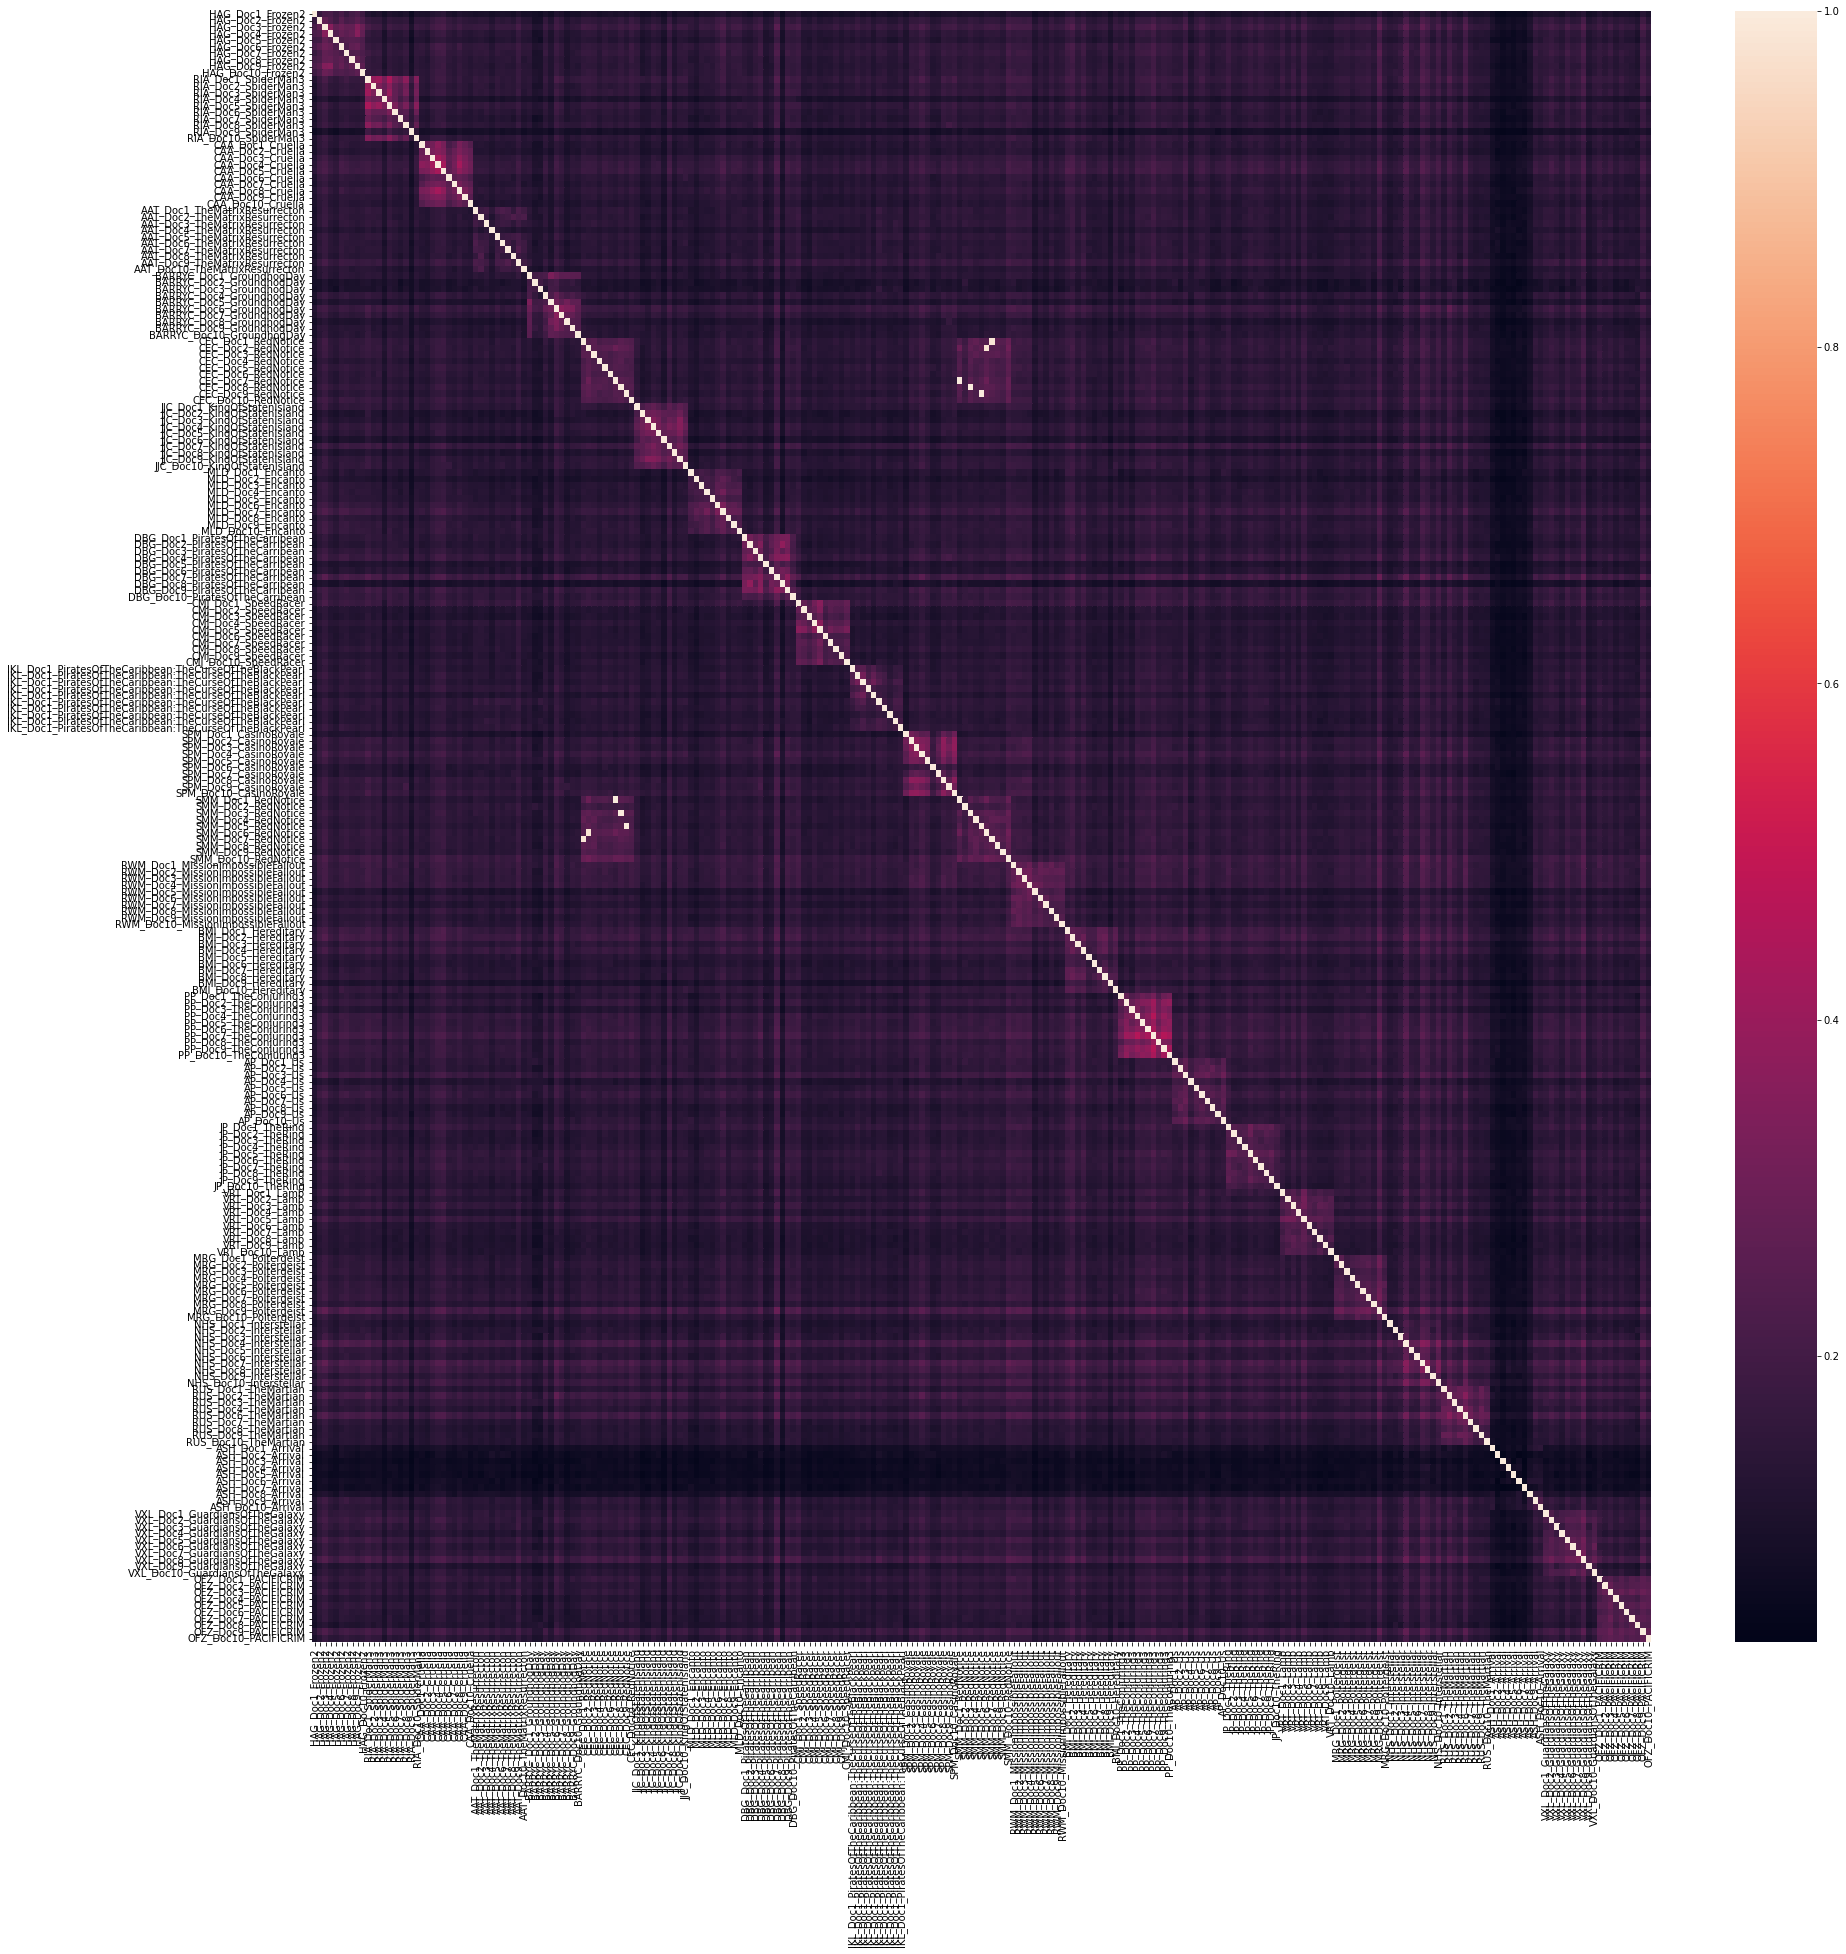

In [82]:
similarity  = cosine_similarity(df, df)
a4_dims = (30, 30)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=similarity, xticklabels= titles, yticklabels=titles);

### Load Class Corpus

Output Directory Pathway - Update to Environment

In [83]:
data=pd.read_csv(path_to_file)

### Process Documents
1. Process documents
2. Create doc2vec matrix
3. Plotting with TSNE

In [84]:
#process documents
titles, final_processed_text, processed_text = process_corpus(data)
print(final_processed_text[0])

Parents you you can can breathe breathe a a sigh sigh of of relief relief Frozen Frozen s s new new showstopper showstopper Into Into the the Unknown Unknown isnt isnt as as aggressive aggressive an an earworm earworm as as Let Let it it Go Go Its Its more more lyrically lyrically complex complex with with a a lot lot more more high high notes notes the the kind kind thatll thatll break break your your eardrums eardrums if if sung sung by by anyone anyone who who isnt isnt Idina Idina Menzel Menzel and and its its hard hard to to imagine imagine a a car car full full of of kids kids howling howling such such a a delicate delicate scale scale for for hours hours upon upon hours hours Frozen Frozen Disneys Disneys sequel sequel to to its its bn bn hit hit is is more more mature mature ambitious ambitious and and intricate intricate than than its its predecessor predecessor That That doesnt doesnt automatically automatically make make it it better better Frozens Frozens success success wa

In [85]:
doc2vec_df = run_doc2vec(final_processed_text, processed_text)
labels, tokens, word2vec_model = run_word2vec(processed_text)
print(len(tokens))

23907


### Plot doc2vec TSNE

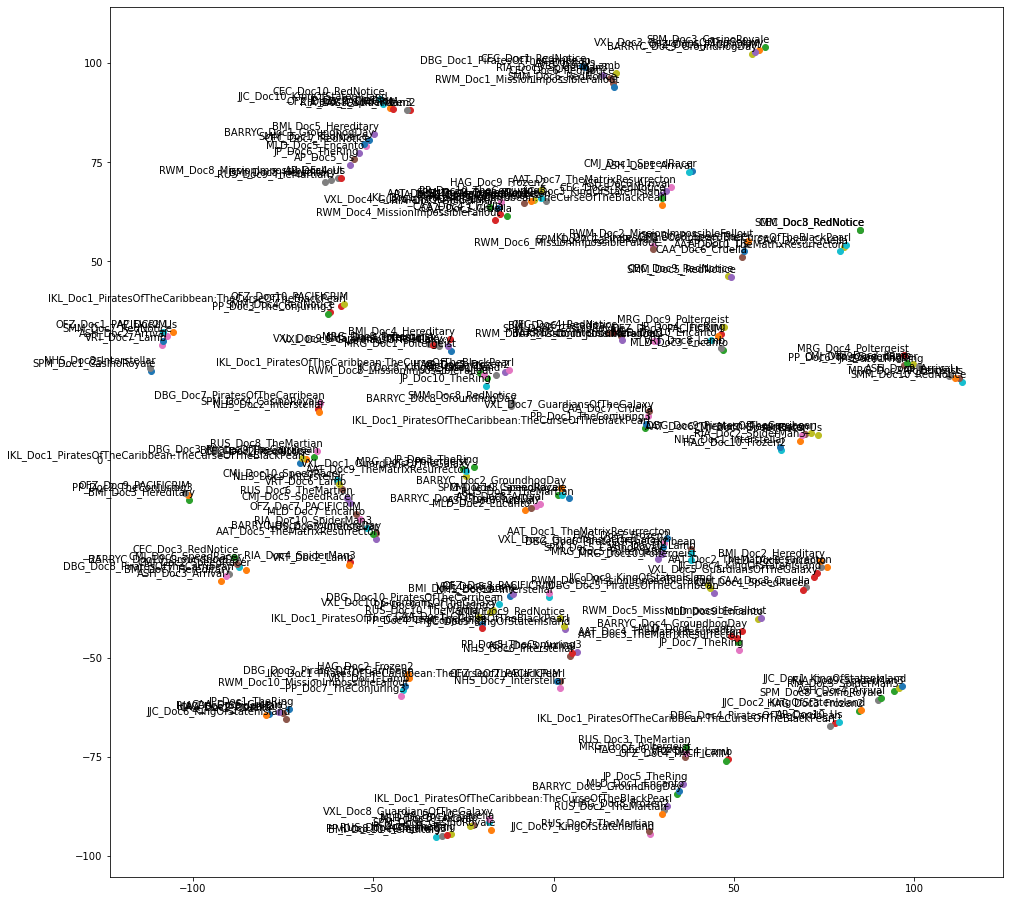

In [86]:
#visualize documents through applying TSNE to doc2vec matrix
pca = PCA(n_components=2).fit(doc2vec_df)
X_pca = pca.transform(doc2vec_df)
tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)
doc2vec_df = tsne_model.fit_transform(X_pca)
x = []
y = []
for value in doc2vec_df:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(titles[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [87]:
##model.train(processed_text,total_examples=model.corpus_count, epochs=30)

In [88]:
#model.docvecs.doctags.keys()

### Plot doc2vec TSNE

In [89]:
# plot_doc2vec(doc2vec_df, titles,15)

### Plot word2vec TSNE

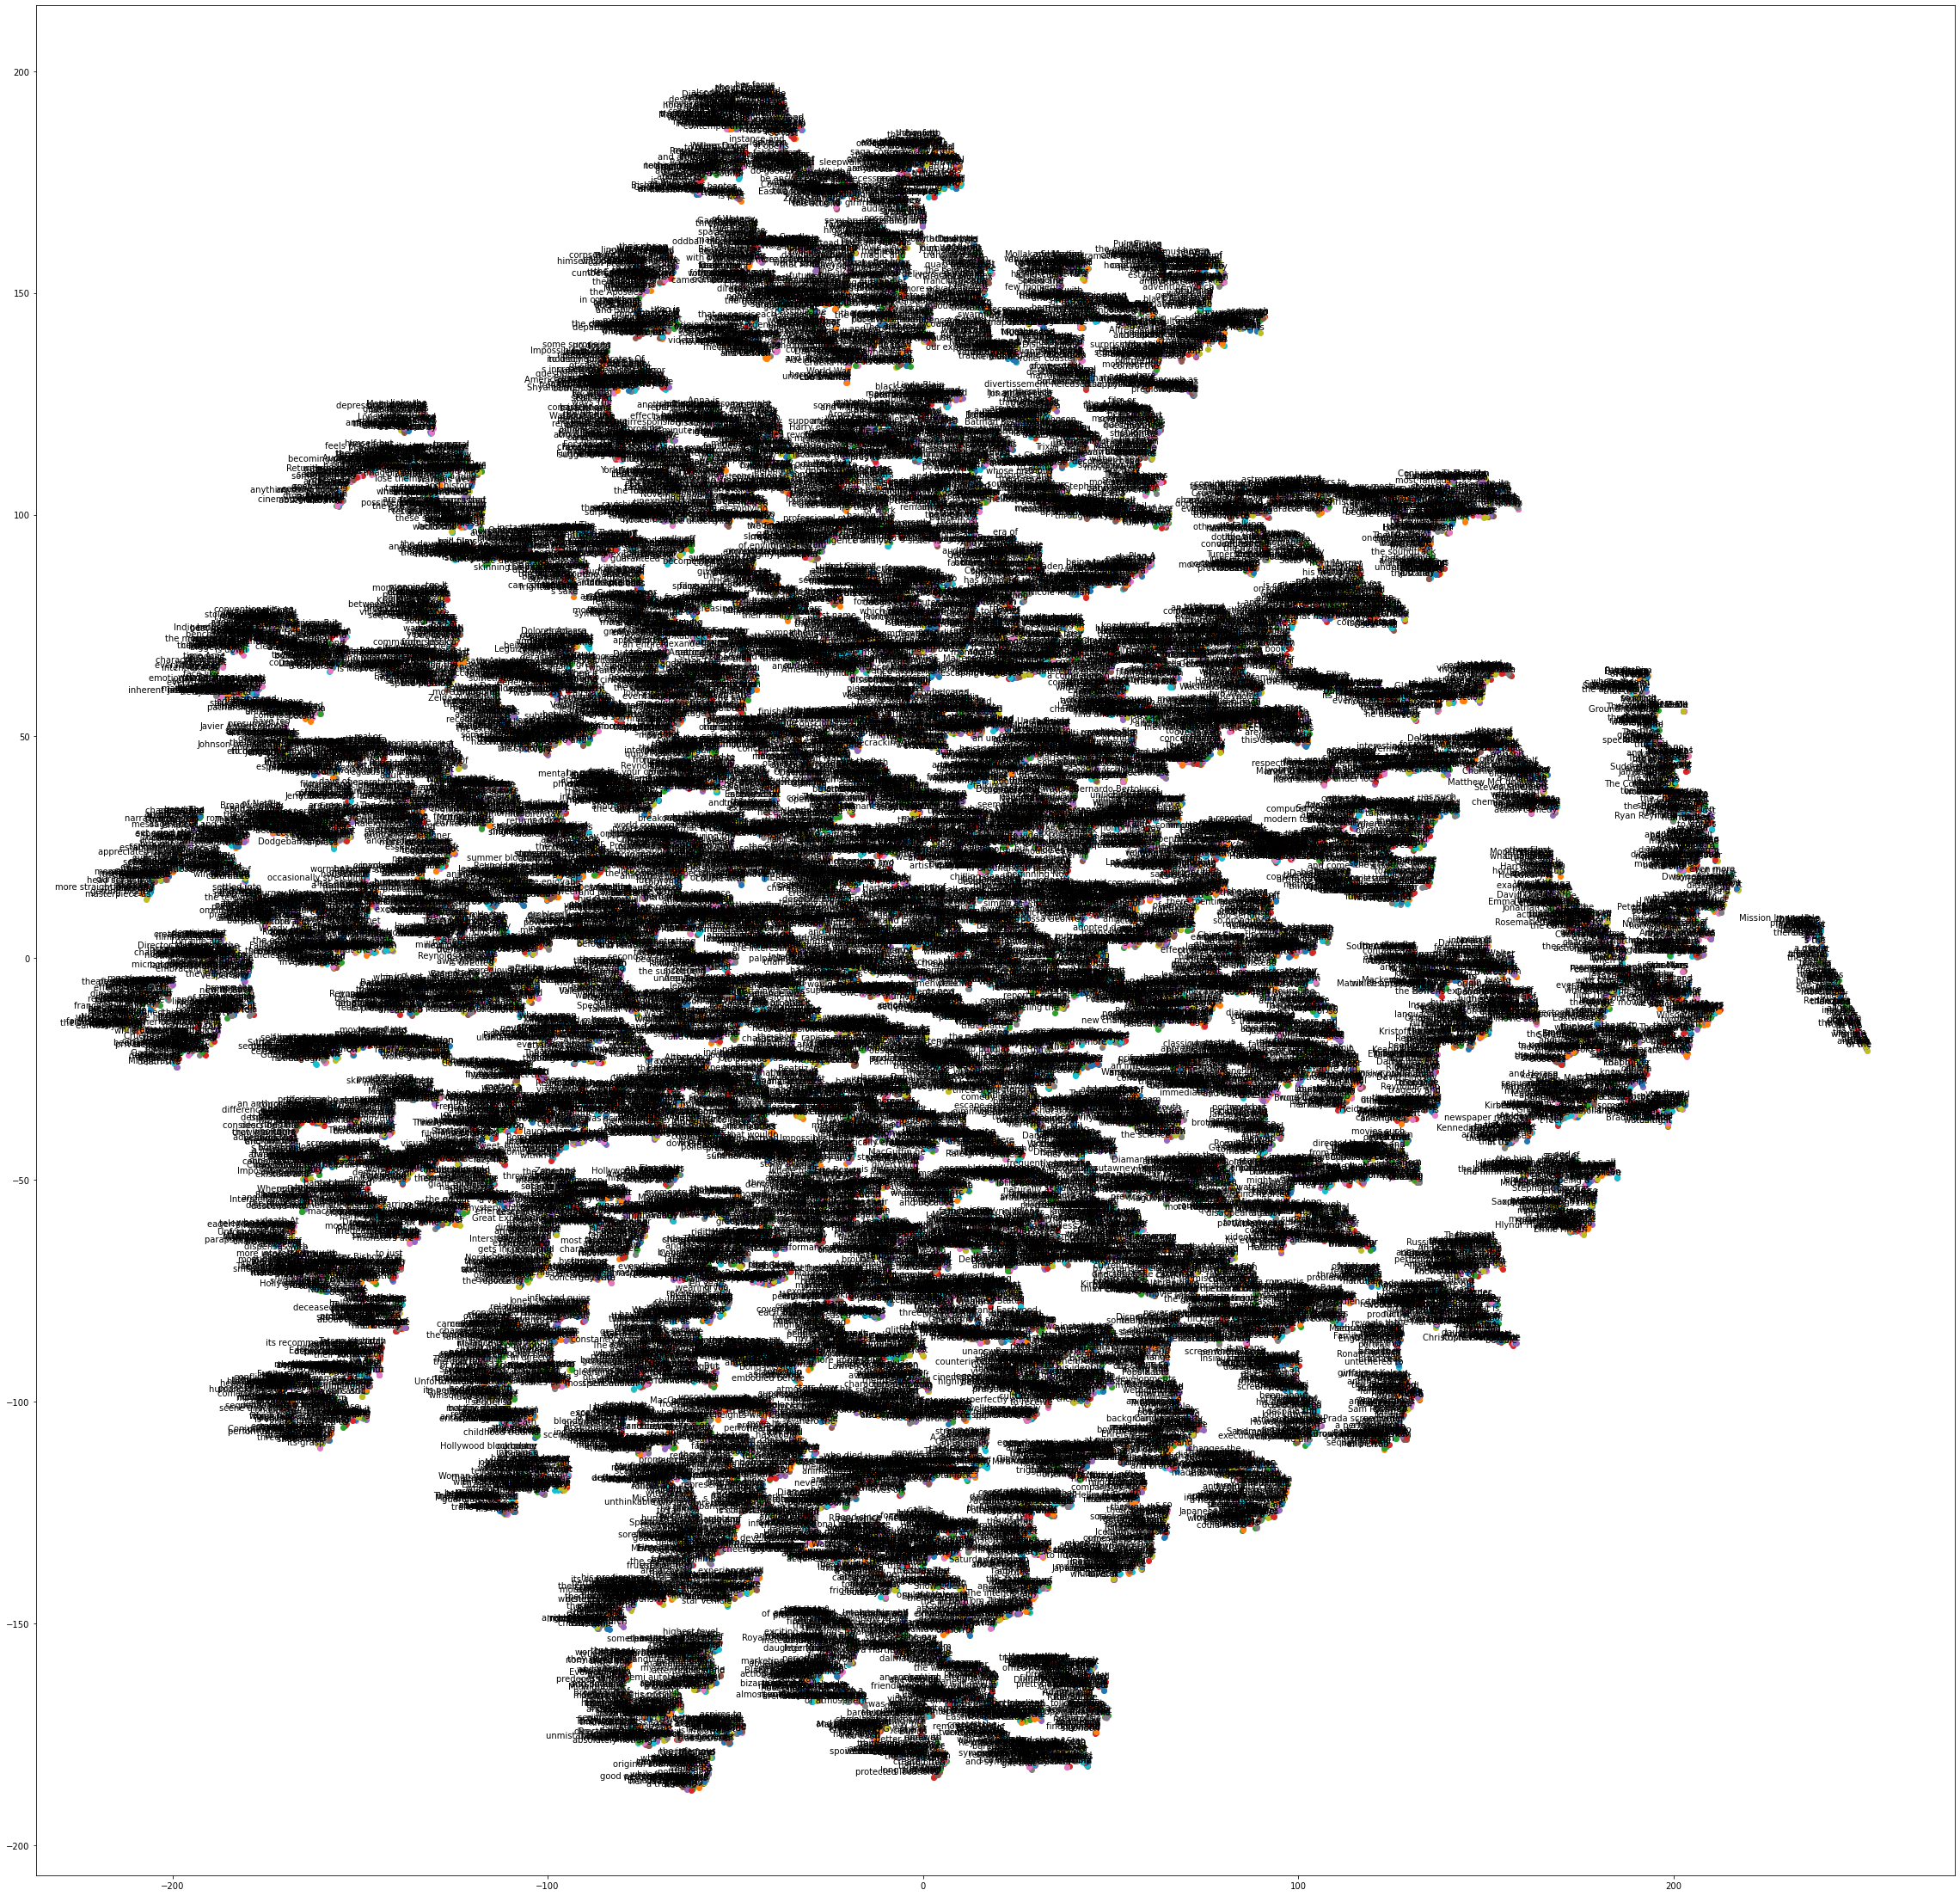

Wall time: 51min 5s


In [90]:
%%time
plot_word2vec(word2vec_model, labels, tokens,15)

In [91]:
# tsne_model= TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
# new_values = tsne_model.fit_transform(w2v_df)
# x = []
# y = []
# for value in new_values:
#     x.append(value[0])
#     y.append(value[1])

# plt.figure(figsize=(16, 16)) 
# for i in range(len(x)):
#     plt.scatter(x[i],y[i])
#     plt.annotate(titles[i],
#                  xy=(x[i], y[i]),
#                  xytext=(5, 2),
#                  textcoords='offset points',
#                  ha='right',
#                  va='bottom')
# plt.show()

### Explore K-means clustering of TFIDF matrix

In [92]:
#############################################
#Calculates tf idf
#Edit ngram range if you like
#############################################
def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(stop_words='english', ngram_range = ngram_range)

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix, words

#############################################
#Performs the k-means clustering of the tfidf matrix
#Edit the number of clusters
#############################################
def k_means_tfidf(tfidf_matrix,terms,titles,final_processed_text, k=10):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    km = KMeans(n_clusters=k, random_state =89)
    km = km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    print("Top terms per cluster:")
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    terms_dict=[]


    #save the terms for each cluster and document to dictionaries.  To be used later
    #for plotting output.

    #dictionary to store terms and titles
    cluster_terms={}
    cluster_title={}


    for i in range(k):
        #print("Cluster %d:" % i),
        temp_terms=[]
        temp_titles=[]
        for ind in order_centroids[i, :10]:
            #print(' %s' % terms[ind])
            terms_dict.append(terms[ind])
            temp_terms.append(terms[ind])
        cluster_terms[i]=temp_terms

        
        #print("Cluster %d titles:" % i, end='')
        temp=frame[frame['Cluster']==i]
        for title in temp['Doc Name']:
            #print(' %s,' % title, end='')
            temp_titles.append(title)
        cluster_title[i]=temp_titles
    return km, cluster_title 

#############################################
# Run the code
#############################################


In [93]:
tfidf_matrix, terms = tfidf(final_processed_text, titles)
k_tfidfmeans_model, clustertfidf_title = k_means_tfidf(tfidf_matrix,terms,titles,final_processed_text, k=4)

Top terms per cluster:


### Implementation of Silhouette Score 
Measurement most optimal number of clusters

In [94]:
k_list = [2, 5, 7, 10]
#silhoutte score list
sil_scores = []

for k in k_list:
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    labels = km.labels_.tolist()
    score = silhouette_score(tfidf_matrix, labels)
    sil_scores.append(score)

### Plot Silhouette Scores

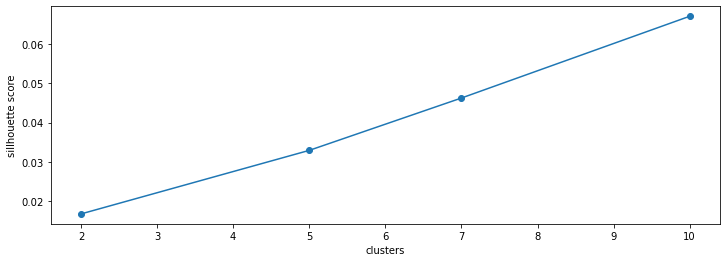

In [95]:
plt.figure(figsize=(12, 4))
plt.scatter(k_list, sil_scores)
plt.plot(k_list, sil_scores)
plt.xlabel("clusters")
plt.ylabel("sillhouette score")
plt.show()

# Elbow Method

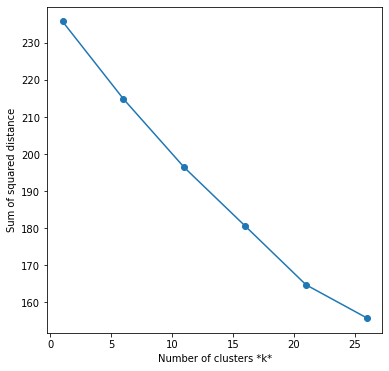

In [96]:

# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 30,5))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(tfidf_matrix)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [97]:
#tfidf_matrix.reset_index(drop=True, inplace=True)

In [98]:
X= tfidf_matrix.values

In [99]:
y_kmeans = k_tfidfmeans_model.predict(tfidf_matrix)

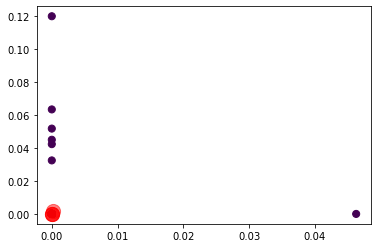

In [100]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = k_tfidfmeans_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);

In [101]:
labels = k_tfidfmeans_model.labels_.tolist()

In [102]:
from sklearn.decomposition import PCA
def get_cluster_scatter_plot(X, kmeans_model, kmeans_labels, title):
    pca = PCA(n_components=2).fit(X)
    datapoint = pca.transform(X)

    plt.figure(figsize=(10, 6))
    label1 = ['#be254a', '#dc484c', '#ef6645', '#f88c51', '#fdb365', '#fed27f', '#feeb9d', '#fffebe', 
'#f0f9a7', '#d8ef9b', '#b3e0a2', '#89d0a4', '#60bba8', '#3f97b7', '#4273b3']#, "#0000FF"]
    color = [label1[i] for i in kmeans_labels]
    scatter = plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

    centroids = kmeans_model.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
    plt.title(title + ' PCA Cluster Plot')
    plt.show()

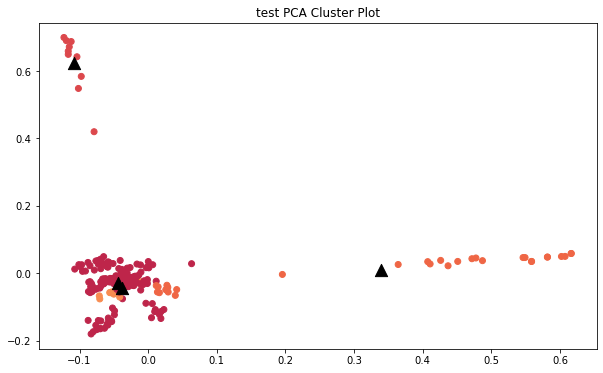

In [103]:
get_cluster_scatter_plot(X, k_tfidfmeans_model, labels, 'test')

### Explore K-means clustering of doc2vec matrix

In [104]:
def doc2vec_with_titles(corpus, processed_text, titles, vector_size = 100):
    #function to created doc2vec matrix
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

    model = Doc2Vec(documents, vector_size=100, window=3, min_count=2, workers=4)

    doc2vec_df=pd.DataFrame()
    for i in range(0,len(processed_text)):
        vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
        doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

    doc2vec_df=doc2vec_df.reset_index()

    doc_titles={'title': titles}
    t=pd.DataFrame(doc_titles)

    doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

    doc2vec_df=doc2vec_df.drop('index', axis=1)
    return doc2vec_df

def k_means_doc2vec(doc2vec_df, final_processed_text,titles, k = 5):
    
    #this is a funciton to create the k_means outputs using the doc2vec matrics.  Required inputs
    #include the doc2vec matrix, and desired number of clusters.
    doc2vec_k_means=doc2vec_df.drop('title', axis=1)

    km = KMeans(n_clusters=k, random_state =89)
    km = km.fit(doc2vec_k_means)

    clusters_d2v = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        #print("Cluster %d:" % i)
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            #print(' %s ' % title, end='\n')
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list
    return km, cluster_title

doc2vec_model = doc2vec_with_titles(final_processed_text, processed_text,titles)
doc2vec_model.index = titles
k_means_model, cluster_title = k_means_doc2vec(doc2vec_model, final_processed_text,titles, k =4)

### Implementation of Silhouette Score 
Measurement most optimal number of clusters

In [105]:
k_list = [2, 5, 7, 10]
#silhoutte score list
sil_scores = []

for k in k_list:
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(doc2vec_df)
    labels = km.labels_.tolist()
    score = silhouette_score(doc2vec_df, labels)
    sil_scores.append(score)

### Plot Silhouette Scores

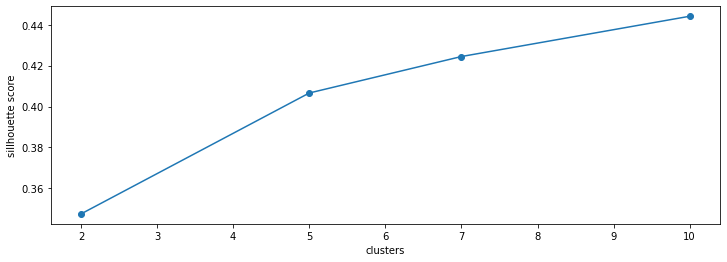

In [106]:
plt.figure(figsize=(12, 4))
plt.scatter(k_list, sil_scores)
plt.plot(k_list, sil_scores)
plt.xlabel("clusters")
plt.ylabel("sillhouette score")
plt.show()

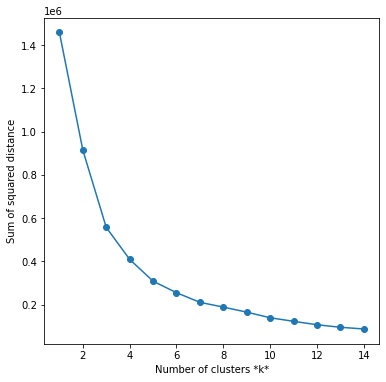

In [107]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(doc2vec_df)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [108]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [109]:
X= doc2vec_model.drop('title', axis=1).values

In [110]:
#doc2vec_model= doc2vec_model.reset_index(drop= True, inplace=True)

In [111]:
y_kmeans = k_means_model.predict(doc2vec_model.drop('title', axis=1))

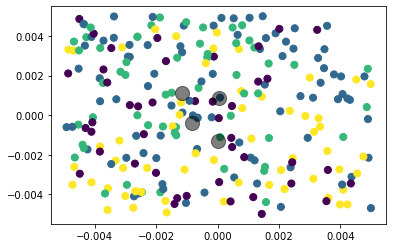

In [112]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = k_means_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [113]:
labels = k_means_model.labels_.tolist()

In [114]:

def get_cluster_scatter_plot(X, kmeans_model, kmeans_labels, title):
    pca = PCA(n_components=2).fit(X)
    datapoint = pca.transform(X)

    plt.figure(figsize=(10, 6))
    label1 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']#, "#0000FF"]
    color = [label1[i] for i in kmeans_labels]
    #print(color)
    scatter = plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

    centroids = kmeans_model.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
    plt.title(title + ' PCA Cluster Plot')
    plt.show()

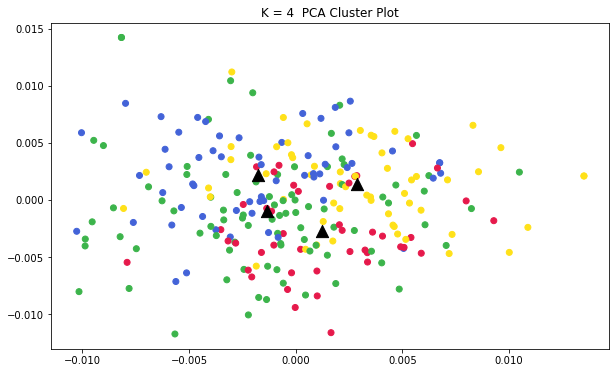

In [115]:
get_cluster_scatter_plot(X, k_means_model, labels, 'K = 4 ')

In [116]:
import seaborn as sns

In [117]:
titles

['HAG_Doc1_Frozen2',
 'HAG_Doc2_Frozen2',
 'HAG_Doc3_Frozen2',
 'HAG_Doc4_Frozen2',
 'HAG_Doc5_Frozen2',
 'HAG_Doc6_Frozen2',
 'HAG_Doc7_Frozen2',
 'HAG_Doc8_Frozen2',
 'HAG_Doc9_Frozen2',
 'HAG_Doc10_Frozen2',
 'RIA_Doc1_SpiderMan3',
 'RIA_Doc2_SpiderMan3',
 'RIA_Doc3_SpiderMan3',
 'RIA_Doc4_SpiderMan3',
 'RIA_Doc5_SpiderMan3',
 'RIA_Doc6_SpiderMan3',
 'RIA_Doc7_SpiderMan3',
 'RIA_Doc8_SpiderMan3',
 'RIA_Doc9_SpiderMan3',
 'RIA_Doc10_SpiderMan3',
 'CAA_Doc1_Cruella',
 'CAA_Doc2_Cruella',
 'CAA_Doc3_Cruella',
 'CAA_Doc4_Cruella',
 'CAA_Doc5_Cruella',
 'CAA_Doc6_Cruella',
 'CAA_Doc7_Cruella',
 'CAA_Doc8_Cruella',
 'CAA_Doc9_Cruella',
 'CAA_Doc10_Cruella',
 'AAT_Doc1_TheMatrixResurrecton',
 'AAT_Doc2_TheMatrixResurrecton',
 'AAT_Doc3_TheMatrixResurrecton',
 'AAT_Doc4_TheMatrixResurrecton',
 'AAT_Doc5_TheMatrixResurrecton',
 'AAT_Doc6_TheMatrixResurrecton',
 'AAT_Doc7_TheMatrixResurrecton',
 'AAT_Doc8_TheMatrixResurrecton',
 'AAT_Doc9_TheMatrixResurrecton',
 'AAT_Doc10_TheMatrixResurrecto

In [118]:
# def get_TSNE_PCA_scatter_plot(X, kmeans_model, kmeans_labels, title):
#     pca = PCA(n_components=2).fit(X)
#     X_pca = pca.transform(X)
#     y = titles

#     # randomly sample data to run quickly
#     rows = np.arange(249)
#     np.random.shuffle(rows)
#     n_select = 200
#     # reduce dimensionality with t-sne
#     tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=3500, learning_rate=2)
#     tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])
#     # visualize
#     df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
#     #print([rows[:n_select]])
#     df_tsne['label'] = y[rows[:n_select]]
#     sns.lmplot(x='comp1', y='comp2', data=df_tsne,  fit_reg=False)
#     plt.show()

In [119]:
get_TSNE_PCA_scatter_plot(X, k_means_model, labels, 'TSNE ')

NameError: name 'get_TSNE_PCA_scatter_plot' is not defined

In [ ]:
# df_tsne